In [1]:
!pip install pandas
!pip install numpy
!pip install pandas-profiling==2.7.1
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import os

!pip install seaborn
import seaborn as sns

from pandas.api.types import CategoricalDtype
Train_label = pd.read_csv('Training set labels.csv')
Train_value = pd.read_csv('Training set values.csv')
Test_value = pd.read_csv('Test set values.csv')
Train = pd.merge(Train_value,Train_label, how='inner',left_on='id',right_on='id', left_index=False)

In [ ]:
# Function to set up # of category for features
test_cat = 8
def max_cat(col):
    if len(Train[col].value_counts()) > (test_cat):
        top_value = Train[col].value_counts()[:(test_cat)].index.tolist()
        Train.loc[-Train[col].isin(top_value),col]='Others'
                
    return Train
        

In [27]:
Train.shape

(59400, 41)

In [ ]:
Train.head()

In [ ]:
Train.isnull().sum()

In [ ]:
# Check for Duplicate values
Train.duplicated().sum()

array([[<AxesSubplot:title={'center':'amount_tsh'}>,
        <AxesSubplot:title={'center':'gps_height'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'num_private'}>,
        <AxesSubplot:title={'center':'region_code'}>],
       [<AxesSubplot:title={'center':'district_code'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'construction_year'}>]], dtype=object)

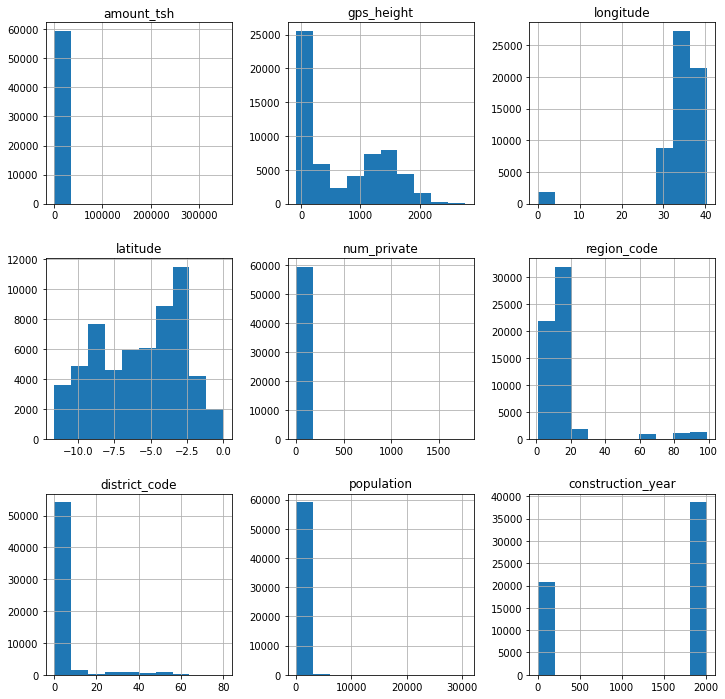

In [2]:
#Check the histogram for numeric features
Train.iloc[:,1:].hist(figsize=(12,12))

###  Clean All Numeric Features

#### Cleanning - amount_tsh
- Outlier

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

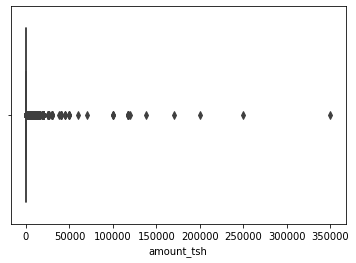

In [15]:
sns.boxplot(Train['amount_tsh'])
Train['amount_tsh'].describe()

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.000000
mean        12.748566
std         20.976109
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max         50.000000
Name: amount_tsh, dtype: float64

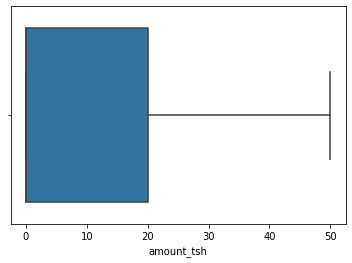

In [3]:
# Inter-Quartile Range (IQR) proximity rule
percentile25 = Train['amount_tsh'].quantile(0.25)
percentile75 = Train['amount_tsh'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# apply the Capping on Outliers
Train['amount_tsh'] = np.where(Train['amount_tsh']>upper_limit,upper_limit,
                      np.where(Train['amount_tsh']<lower_limit,lower_limit,Train['amount_tsh']))

sns.boxplot(Train['amount_tsh'])

Train['amount_tsh'].describe()

#### Cleanning - 'gps_height'
After checking, nothing to be dealed with

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

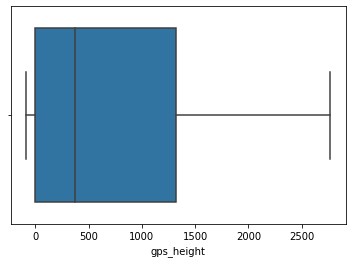

In [17]:
sns.boxplot(Train['gps_height'])
Train['gps_height'].describe()

#### Cleanning - longitude | latitude
Reference: https://worldpopulationreview.com/country-locations/where-is-tanzania    
latitude :  00°59' - 11°45′ -> should be negative due South Lat  -> -0.59  ~ - 11.45
longitude:  29°10' -  40°29′ East

In [18]:
Train[['longitude','latitude']].describe()

,longitude,latitude
count,59400.000000,5.940000e+04
mean,34.077427,-5.706033e+00
std,6.567432,2.946019e+00
min,0.000000,-1.164944e+01
25%,33.090347,-8.540621e+00
50%,34.908743,-5.021597e+00
75%,37.178387,-3.326156e+00
max,40.345193,-2.000000e-08


In [4]:
long_lat_error =Train[((Train['longitude'] < 29.10)  | (Train['longitude'] > 40.29)) | ((Train['latitude'] < -11.45)  | (Train['latitude'] > -0.59))] 


In [5]:
# Correct long_lat_error using mean of corrected  long & lat
long_mean = Train[(Train['longitude'] >= 29.10)  | (Train['longitude'] <= 40.29)]['longitude'].mean()
lat_mean = Train[(Train['latitude'] >= -11.45)  | (Train['latitude'] <= -0.59)]['latitude'].mean()
#long_mean: 34.077426692028794
#lat_mean: -5.706032659626431
                  

In [6]:
Train['longitude'] = np.where(((Train.longitude <29.10 ) | (Train.longitude > 40.29)),long_mean,Train.longitude)
Train['latitude'] = np.where(((Train.latitude < -11.45) | (Train.latitude > -0.59)),lat_mean,Train.latitude)

In [7]:
# Test long_lat_error -> should be zero instance 
long_lat_error =Train[((Train['longitude'] < 29.10)  | (Train['longitude'] > 40.29)) | ((Train['latitude'] < -11.45)  | (Train['latitude'] > -0.59))] 
long_lat_error # zero instance
Train[['longitude','latitude']].describe()

,longitude,latitude
count,59400.000000,59400.000000
mean,35.114020,-5.871996
std,2.571584,2.758860
min,29.607122,-11.449849
25%,33.354079,-8.524319
50%,34.905440,-5.440285
75%,37.173618,-3.398151
max,40.287471,-0.998464


In [46]:
# export long & lat data with status for heatmap
df_long_lat = Train[['longitude','latitude','status_group']]
df_long_lat.to_csv("long_lat_status.csv")

#### Cleanning - 'num_private'
-Outlier

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.000000
mean         0.474141
std         12.236230
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

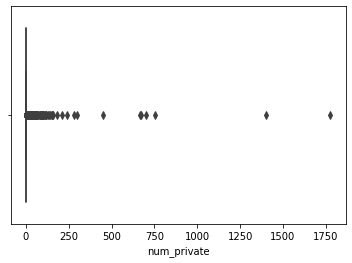

In [25]:
sns.boxplot(Train['num_private'])
Train['num_private'].describe()

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_private, dtype: float64

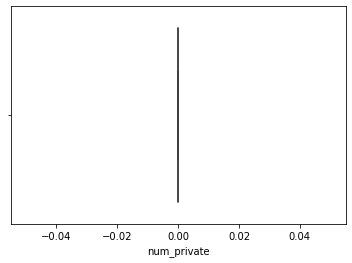

In [8]:
# Inter-Quartile Range (IQR) proximity rule
percentile25 = Train['num_private'].quantile(0.25)
percentile75 = Train['num_private'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# apply the Capping on Outliers
Train['num_private'] = np.where(Train['num_private']>upper_limit,upper_limit,
                      np.where(Train['num_private']<lower_limit,lower_limit,Train['num_private']))

sns.boxplot(Train['num_private'])

Train['num_private'].describe()

#### Cleanning - region | region_code
Reference : https://www.worldatlas.com/maps/tanzania
Standerdize region code with region
Reference: https://www.citypopulation.de/en/tanzania/admin/

In [9]:
df_region_error = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)


In [10]:
df = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)
df.to_csv('region_error.csv')
Train.loc[Train['region_code'] == 24,'region_code'] = 2
Train.loc[(Train['region_code'] == 18 )| (Train['region_code'] == 80),'region_code' ] = 8
Train.loc[(Train['region_code'] == 90 )| (Train['region_code'] == 99),'region_code' ] = 9
Train.loc[(Train['region_code'] == 17) & (Train['region'] == 'Mwanza'),'region_code'] = 19
Train.loc[(Train['region_code'] == 60 )| (Train['region_code'] == 40),'region_code'] = 6
Train.loc[(Train['region_code'] == 5)  & (Train['region'] == 'Tanga') ,'region_code' ] = 4
Train.loc[(Train['region_code'] == 11) & (Train['region'] == 'Shinyanga'),'region_code'] = 17
Train.loc[(Train['region_code'] == 14 )& (Train['region'] == 'Shinyanga'),'region_code'] = 17

df = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)
df
                                    

region_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21
region,,,,,,,,,,,,,,,,,,,,
Arusha,0,3350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dar es Salaam,0,0,0,0,0,0,805,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,2201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,0,0,0,0,0,0,0,0,0,0,5294,0,0,0,0,0,0,0,0,0
Kagera,0,0,0,0,0,0,0,3316,0,0,0,0,0,0,0,0,0,0,0,0
Kigoma,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2816,0,0,0,0
Kilimanjaro,0,0,4379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,0,0,0,0,0,0,0,1546,0,0,0,0,0,0,0,0,0,0,0,0
Manyara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1583


In [3]:
df_region = Train.pivot_table('id','region','status_group',aggfunc='count')
df_region.to_csv('reg_status.csv')

#### Cleanning - district_code
code with 0 -> no sense

In [30]:
Train['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [12]:
df_district_error = Train.pivot_table('id','region','district_code',aggfunc='count').fillna(0).astype(int)
# district_code with 0 -> error   

In [13]:
Train.loc[Train['district_code'] == 0,'district_code'] = 1
df_district = Train.pivot_table('id','region','district_code',aggfunc='count').fillna(0).astype(int) 
df_district

district_code,1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67,80
region,,,,,,,,,,,,,,,,,,,
Arusha,189,1206,109,0,201,310,1009,0,0,0,326,0,0,0,0,0,0,0,0
Dar es Salaam,93,497,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,911,0,361,347,358,224,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,728,530,650,2473,564,0,349,0,0,0,0,0,0,0,0,0,0,0,0
Kagera,771,487,402,403,0,88,260,236,0,0,669,0,0,0,0,0,0,0,0
Kigoma,874,1159,727,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kilimanjaro,595,519,877,1225,620,109,434,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,1,7,300,0,0,0,0,0,391,293,0,0,154,291,0,109,0,0,0
Manyara,550,274,297,276,186,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Cleanning - 'population'

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

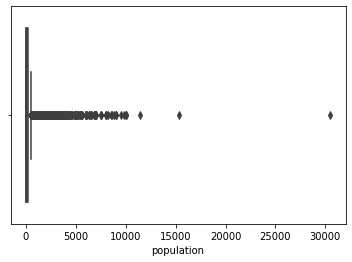

In [55]:
sns.boxplot(Train['population'])
Train['population'].describe()

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    59400.000000
mean       128.424537
std        175.514950
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max        537.500000
Name: population, dtype: float64

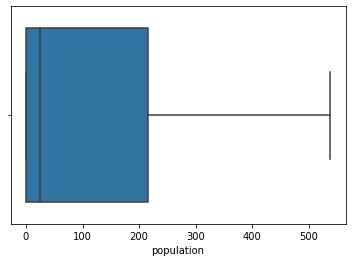

In [15]:
# Inter-Quartile Range (IQR) proximity rule
percentile25 = Train['population'].quantile(0.25)
percentile75 = Train['population'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# apply the Capping on Outliers
Train['population'] = np.where(Train['population']>upper_limit,upper_limit,
                      np.where(Train['population']<lower_limit,lower_limit,Train['population']))

sns.boxplot(Train['population'])
Train['population'].describe()

#### Cleanning - 'construction_year'
- Missing Value
- Outlier

#### Cleanning - lga 
no errors
Cosider Rural vs Urban - to be visulization

In [3]:
Train["lga"].value_counts() #125

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [52]:
df_lga = Train[["region","lga","status_group"]]
df_lga['status_cat'] = df_lga['status_group'].astype('category')
df_lga['status_group'] = df_lga['status_group'].astype('category')
df_lga.info()
df_lga.info()
df_lga['status_cat']= df_lga['status_group'].cat.codes
df_lga = df_lga.pivot_table(df_lga, index = ['region','lga'], columns = 'status_group',aggfunc= 'count' )
df_lga

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   region        59400 non-null  object  
 1   lga           59400 non-null  object  
 2   status_group  59400 non-null  category
 3   status_cat    59400 non-null  category
dtypes: category(2), object(2)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   region        59400 non-null  object  
 1   lga           59400 non-null  object  
 2   status_group  59400 non-null  category
 3   status_cat    59400 non-null  category
dtypes: category(2), object(2)
memory usage: 1.5+ MB


/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


status_cat                                       
status_group        functional functional needs repair non functional
region lga                                                           
Arusha Arusha Rural        875                      48            329
       Arusha Urban         42                       7             14
       Babati                0                       0              0
       Bagamoyo              0                       0              0
       Bahi                  0                       0              0
...                        ...                     ...            ...
Tanga  Tunduru               0                       0              0
       Ukerewe               0                       0              0
       Ulanga                0                       0              0
       Urambo                0                       0              0
       Uyui                  0                       0              0

[2625 rows x 3 columns]

In [53]:
df_lga = pd.DataFrame(df_lga.to_records())
#df_lga.loc[df_lga["lga"].str.contains(("Rural"), case=False)][["region","lga",]]
df_lga.loc[df_lga["lga"].str.contains(("Rural"), case=False)][:]#9552
#df_lga.loc[Train["lga"].str.contains("Urban", case=False)]["lga"] #1683
df_lga.columns[3]

df_lga  = df_lga.rename(columns={"('status_cat', 'functional')":'functional',
                       "('status_cat', 'functional needs repair')":'functional needs repair',
                       "('status_cat', 'non functional')":'non functional'})
df_lga_status = df_lga.loc[df_lga["functional"] != 0]    

df_lga_status 

,region,lga,functional,functional needs repair,non functional
0,Arusha,Arusha Rural,875,48,329
1,Arusha,Arusha Urban,42,7,14
27,Arusha,Karatu,316,1,9
50,Arusha,Longido,200,29,81
65,Arusha,Meru,657,32,320
...,...,...,...,...,...
2552,Tanga,Lushoto,433,59,202
2568,Tanga,Mkinga,224,0,64
2580,Tanga,Muheza,219,0,115
2595,Tanga,Pangani,65,3,237


In [17]:
#Export region_lga for visulization
df_lga_status.to_csv('df_lga_status.csv')


#### Cleanning - ward
There 2092 uniqu value - consider use function max_cat to pick top value
The Ward Profiles provide demographic information on population by age, households and dwelling types, families, language group, household tenure and period of construction; immigration, mobility, ethnic origin and visible minorities; education and labour force; income and shelter cost. 

In [35]:
Train["ward"].value_counts() #2092
#max_cat('ward')

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

#### Cleanning - Public_meeting
Replace Public_meeting missing values by unknown

In [54]:
Train['public_meeting'].fillna(Train['public_meeting'].mode()[0], inplace=True)

### Cleanning - source | source type | source_calss

In [36]:
# Source #10
Train.groupby('source')['id'].nunique().sort_values(ascending=False)
#10  Combine other & Unknow ;  source vs source_type similar, to consider use source_type for model
Train.pivot_table('id','status_group','source',aggfunc='count').fillna(0).astype(int)

source,dam,hand dtw,lake,machine dbh,other,rainwater harvesting,river,shallow well,spring,unknown
status_group,,,,,,,,,,
functional,253,497,162,5422,126,1386,5465,8324,10592,32
functional needs repair,24,17,12,491,1,314,1221,957,1276,4
non functional,379,360,591,5162,85,595,2926,7543,5153,30


In [37]:
# Source type #7
Train.groupby('source_type')['id'].nunique().sort_values(ascending=False) 
Train.pivot_table('id','status_group','source_type',aggfunc='count').fillna(0).astype(int)

source_type,borehole,dam,other,rainwater harvesting,river/lake,shallow well,spring
status_group,,,,,,,
functional,5919,253,158,1386,5627,8324,10592
functional needs repair,508,24,5,314,1233,957,1276
non functional,5522,379,115,595,3517,7543,5153


In [38]:
# source_class #3 
Train.groupby('source_class')['id'].nunique().sort_values(ascending=False) #3
Train.pivot_table('id','status_group','source_class',aggfunc='count').fillna(0).astype(int)

source_class,groundwater,surface,unknown
status_group,,,
functional,24835,7266,158
functional needs repair,2741,1571,5
non functional,18218,4491,115


### Cleanning -  waterpoint_type  | waterpoint_type_group 

In [8]:
Train.groupby('waterpoint_type')['id'].nunique().sort_values(ascending=False) #7
Train.pivot_table('id','status_group','waterpoint_type',aggfunc='count').fillna(0).astype(int)

waterpoint_type,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
status_group,,,,,,,
functional,84,17726,2235,6,10805,563,840
functional needs repair,2,2260,648,0,1029,85,293
non functional,30,8536,3220,1,5654,136,5247


In [9]:
Train.groupby('waterpoint_type_group')['id'].nunique().sort_values(ascending=False) #6
Train.pivot_table('id','status_group','waterpoint_type_group',aggfunc='count').fillna(0).astype(int)

waterpoint_type_group,cattle trough,communal standpipe,dam,hand pump,improved spring,other
status_group,,,,,,
functional,84,19961,6,10805,563,840
functional needs repair,2,2908,0,1029,85,293
non functional,30,11756,1,5654,136,5247


In [21]:
Train["region"].value_counts()  #21
# len(Train["region"].value_counts())
#max_cat('region')
#Train[Train['region'] =='Others']

21

In [5]:
Train['population'].describe()
#Train['population']

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

<AxesSubplot:xlabel='population', ylabel='Density'>

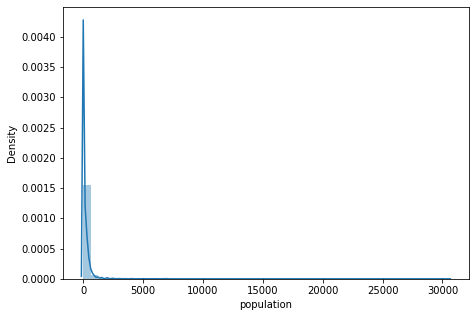

In [6]:
Train[Train['population'] == 0]  # 21381 records  => zero population
#https://worldpopulationreview.com/countries/tanzania-population
#https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(Train['population']) # left skewed 

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='population'>

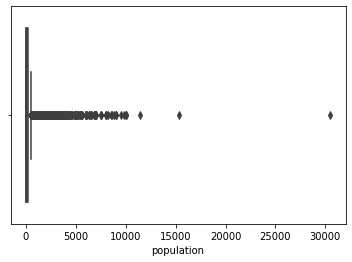

In [16]:
sns.boxplot(Train['population'])

In [3]:
Train[['region','population']]
df_pop = Train.pivot_table('id','region','population',aggfunc='sum').fillna(0).astype(int) 
df_pop['sum'] = df_pop.sum(axis = 1)
df_pop['sum']

region
Arusha           125452610
Dar es Salaam     30017353
Dodoma            80760619
Iringa           194159068
Kagera           123713407
Kigoma           102667532
Kilimanjaro      163126393
Lindi             57574121
Manyara           59102904
Mara              74861850
Mbeya            174055235
Morogoro         148280588
Mtwara            63791546
Mwanza           116488810
Pwani             97304169
Rukwa             67564706
Ruvuma            99180138
Shinyanga        182679138
Singida           76474025
Tabora            72555411
Tanga             94829204
Name: sum, dtype: int64

In [18]:
#  empirical relations of Normal distribution
upper_limit = Train['population'].mean() + 3*Train['population'].std() # h 1594.3565103804244
lower_limit = Train['population'].mean() - 3*Train['population'].std() # l -1234.536544050458 --> should zero
lower_limit = 0 if lower_limit < 0 else lower_limit
#lower_limit
#upper_limit

# apply the Capping on Outliers
Train['population'] = np.where(Train['population']>upper_limit,upper_limit,
                      np.where(Train['population']<lower_limit,lower_limit,Train['population']))

Train['population'].describe()


count    59400.000000
mean       159.565369
std        281.071681
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max       1594.356510
Name: population, dtype: float64

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='population'>

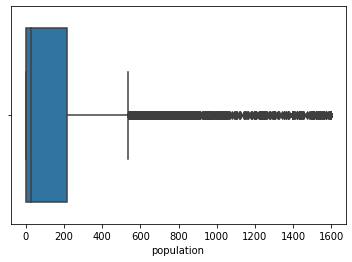

In [19]:
sns.boxplot(Train['population'])

In [12]:
#  Percentile 
upper_limit = Train['population'].quantile(0.99) # h 2000
lower_limit = Train['population'].quantile(0.01) # l -1234.536544050458 --> should zero
lower_limit = 0 if lower_limit < 0 else lower_limit
lower_limit
upper_limit

# apply the Capping on Outliers
Train['population'] = np.where(Train['population']>upper_limit,upper_limit,
                      np.where(Train['population']<lower_limit,lower_limit,Train['population']))

Train['population'].describe()



count    59400.000000
mean       164.056936
std        306.005667
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max       2000.000000
Name: population, dtype: float64

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='population'>

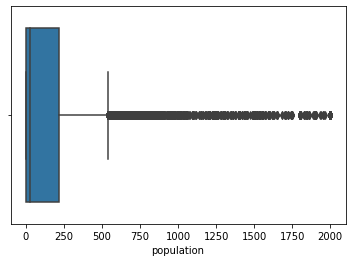

In [13]:
sns.boxplot(Train['population'])

In [19]:
# Inter-Quartile Range (IQR) proximity rule
percentile25 = Train['population'].quantile(0.25)
percentile75 = Train['population'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
lower_limit = 0 if lower_limit < 0 else lower_limit
# apply the Capping on Outliers
Train['population'] = np.where(Train['population']>upper_limit,upper_limit,
                      np.where(Train['population']<lower_limit,lower_limit,Train['population']))

Train['population'].describe()


count    59400.000000
mean       128.424537
std        175.514950
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max        537.500000
Name: population, dtype: float64

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='population'>

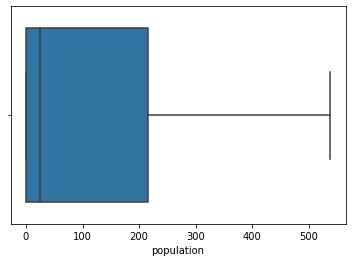

In [20]:
sns.boxplot(Train['population'])

#### Cleanning - 'public_meeting'
- Missing Value

Text(0.5, 1.0, 'Public Meeting')

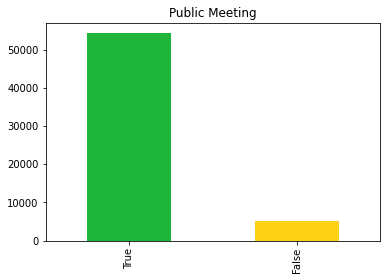

In [16]:
# Replace Public_meeting missing values by unknown
Train['public_meeting'].fillna(Train['public_meeting'].mode()[0], inplace=True)
tanzania_flag_colors = ['#1eb53a', '#fcd116', '#00a3dd', 'black']
Train.public_meeting.value_counts().plot(kind='bar', color=tanzania_flag_colors);
plt.title("Public Meeting")